In [ ]:
!pip install tsfresh
!pip install catboost

In [37]:
%matplotlib inline
import matplotlib.pylab as plt

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import pandas as pd
import numpy as np

## Load and visualize data

In [38]:
# fetch dataset from uci
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
import pandas as pd 

tsfresh = pd.read_csv('/content/tsfresh_multi.csv')
catch = pd.read_csv('/content/catch_multi.csv')

print('tsfresh multivariate dataset: ', tsfresh.shape)
print('catch22 multivariate dataset: ', catch.shape)

tsfresh_X = tsfresh.drop(['class'], axis = 1)
catch_X = catch.drop(['class'], axis = 1)

print('tsfresh multivariate dataset w/o class label: ', tsfresh_X.shape)
print('catch22 multivariate dataset w/o class label: ', catch_X.shape)

tsfresh multivariate dataset:  (88, 4675)
catch22 multivariate dataset:  (88, 133)
tsfresh multivariate dataset w/o class label:  (88, 4674)
catch22 multivariate dataset w/o class label:  (88, 132)


In [39]:
df = pd.concat([tsfresh['class'],tsfresh_X, catch_X], axis = 1)
print('combined multivariate dataset w/ class label: ', df.shape)

combined multivariate dataset w/ class label:  (88, 4807)


## Drop features with Nan values

In [40]:
#drop rows with nan
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]

rows_with_NaN

,class,var4__variance_larger_than_standard_deviation,var4__has_duplicate_max,var4__has_duplicate_min,var4__has_duplicate,var4__sum_values,var4__abs_energy,var4__mean_abs_change,var4__mean_change,var4__mean_second_derivative_central,var4__median,var4__mean,var4__length,var4__standard_deviation,var4__variation_coefficient,var4__variance,var4__skewness,var4__kurtosis,var4__absolute_sum_of_changes,var4__longest_strike_below_mean,var4__longest_strike_above_mean,var4__count_above_mean,var4__count_below_mean,var4__last_location_of_maximum,var4__first_location_of_maximum,var4__last_location_of_minimum,var4__first_location_of_minimum,var4__percentage_of_reoccurring_values_to_all_values,var4__percentage_of_reoccurring_datapoints_to_all_datapoints,var4__sum_of_reoccurring_values,var4__sum_of_reoccurring_data_points,var4__ratio_value_number_to_time_series_length,var4__sample_entropy,var4__maximum,var4__minimum,var4__benford_correlation,var4__time_reversal_asymmetry_statistic__lag_1,var4__time_reversal_asymmetry_statistic__lag_2,var4__time_reversal_asymmetry_statistic__lag_3,var4__c3__lag_1,...,CO_HistogramAMI_even_2_5_var5,CO_trev_1_num_var5,MD_hrv_classic_pnn40_var5,SB_BinaryStats_mean_longstretch1_var5,SB_TransitionMatrix_3ac_sumdiagcov_var5,PD_PeriodicityWang_th0_01_var5,CO_Embed2_Dist_tau_d_expfit_meandiff_var5,IN_AutoMutualInfoStats_40_gaussian_fmmi_var5,FC_LocalSimple_mean1_tauresrat_var5,DN_OutlierInclude_p_001_mdrmd_var5,DN_OutlierInclude_n_001_mdrmd_var5,SP_Summaries_welch_rect_area_5_1_var5,SB_BinaryStats_diff_longstretch0_var5,SB_MotifThree_quantile_hh_var5,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1_var5,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1_var5,SP_Summaries_welch_rect_centroid_var5,FC_LocalSimple_mean3_stderr_var5,DN_HistogramMode_5_var6,DN_HistogramMode_10_var6,CO_f1ecac_var6,CO_FirstMin_ac_var6,CO_HistogramAMI_even_2_5_var6,CO_trev_1_num_var6,MD_hrv_classic_pnn40_var6,SB_BinaryStats_mean_longstretch1_var6,SB_TransitionMatrix_3ac_sumdiagcov_var6,PD_PeriodicityWang_th0_01_var6,CO_Embed2_Dist_tau_d_expfit_meandiff_var6,IN_AutoMutualInfoStats_40_gaussian_fmmi_var6,FC_LocalSimple_mean1_tauresrat_var6,DN_OutlierInclude_p_001_mdrmd_var6,DN_OutlierInclude_n_001_mdrmd_var6,SP_Summaries_welch_rect_area_5_1_var6,SB_BinaryStats_diff_longstretch0_var6,SB_MotifThree_quantile_hh_var6,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1_var6,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1_var6,SP_Summaries_welch_rect_centroid_var6,FC_LocalSimple_mean3_stderr_var6
38,3,0.0,1.0,1.0,1.0,-43.0,125.0,0.214286,0.071429,0.038462,-3.0,-2.866667,15.0,0.339935,-0.118582,0.115556,2.404763,4.349112,3.0,10.0,1.0,2.0,13.0,1.000000,0.200000,0.933333,0.0,1.0,1.0,-5.0,-43.0,0.133333,0.414434,-2.0,-3.0,0.109212,1.153846,0.000000,0.000000,-24.230769,...,0.19069,0.000000,0.571429,3.0,0.057823,3,0.438285,2.0,1.0,0.333333,-0.066667,8.217301e-34,2.0,1.272090,0.0,0.0,1.570796,1.217092,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,3,0.0,1.0,1.0,1.0,-38.0,100.0,0.571429,0.000000,-0.076923,-3.0,-2.533333,15.0,0.498888,-0.196929,0.248889,0.148961,-2.307692,8.0,4.0,3.0,7.0,8.0,0.933333,0.066667,1.000000,0.0,1.0,1.0,-5.0,-38.0,0.133333,1.280934,-2.0,-3.0,0.258588,0.000000,1.363636,0.555556,-15.846154,...,0.10919,1.822708,0.785714,3.0,0.068027,3,0.294895,1.0,1.0,-0.066667,0.200000,3.286920e-33,2.0,1.254042,0.0,0.0,2.356194,1.066744,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
df = df.drop([38, 43]).reset_index(drop = True)

In [42]:
print('combined multivariate dataset w/ class label (nan removed): ', df.shape)
df.head()

combined multivariate dataset w/ class label (nan removed):  (86, 4807)


,class,var4__variance_larger_than_standard_deviation,var4__has_duplicate_max,var4__has_duplicate_min,var4__has_duplicate,var4__sum_values,var4__abs_energy,var4__mean_abs_change,var4__mean_change,var4__mean_second_derivative_central,var4__median,var4__mean,var4__length,var4__standard_deviation,var4__variation_coefficient,var4__variance,var4__skewness,var4__kurtosis,var4__absolute_sum_of_changes,var4__longest_strike_below_mean,var4__longest_strike_above_mean,var4__count_above_mean,var4__count_below_mean,var4__last_location_of_maximum,var4__first_location_of_maximum,var4__last_location_of_minimum,var4__first_location_of_minimum,var4__percentage_of_reoccurring_values_to_all_values,var4__percentage_of_reoccurring_datapoints_to_all_datapoints,var4__sum_of_reoccurring_values,var4__sum_of_reoccurring_data_points,var4__ratio_value_number_to_time_series_length,var4__sample_entropy,var4__maximum,var4__minimum,var4__benford_correlation,var4__time_reversal_asymmetry_statistic__lag_1,var4__time_reversal_asymmetry_statistic__lag_2,var4__time_reversal_asymmetry_statistic__lag_3,var4__c3__lag_1,...,CO_HistogramAMI_even_2_5_var5,CO_trev_1_num_var5,MD_hrv_classic_pnn40_var5,SB_BinaryStats_mean_longstretch1_var5,SB_TransitionMatrix_3ac_sumdiagcov_var5,PD_PeriodicityWang_th0_01_var5,CO_Embed2_Dist_tau_d_expfit_meandiff_var5,IN_AutoMutualInfoStats_40_gaussian_fmmi_var5,FC_LocalSimple_mean1_tauresrat_var5,DN_OutlierInclude_p_001_mdrmd_var5,DN_OutlierInclude_n_001_mdrmd_var5,SP_Summaries_welch_rect_area_5_1_var5,SB_BinaryStats_diff_longstretch0_var5,SB_MotifThree_quantile_hh_var5,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1_var5,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1_var5,SP_Summaries_welch_rect_centroid_var5,FC_LocalSimple_mean3_stderr_var5,DN_HistogramMode_5_var6,DN_HistogramMode_10_var6,CO_f1ecac_var6,CO_FirstMin_ac_var6,CO_HistogramAMI_even_2_5_var6,CO_trev_1_num_var6,MD_hrv_classic_pnn40_var6,SB_BinaryStats_mean_longstretch1_var6,SB_TransitionMatrix_3ac_sumdiagcov_var6,PD_PeriodicityWang_th0_01_var6,CO_Embed2_Dist_tau_d_expfit_meandiff_var6,IN_AutoMutualInfoStats_40_gaussian_fmmi_var6,FC_LocalSimple_mean1_tauresrat_var6,DN_OutlierInclude_p_001_mdrmd_var6,DN_OutlierInclude_n_001_mdrmd_var6,SP_Summaries_welch_rect_area_5_1_var6,SB_BinaryStats_diff_longstretch0_var6,SB_MotifThree_quantile_hh_var6,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1_var6,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1_var6,SP_Summaries_welch_rect_centroid_var6,FC_LocalSimple_mean3_stderr_var6
0,3,1.0,0.0,1.0,1.0,-60.0,344.0,3.214286,0.071429,-0.076923,-5.0,-4.000000,15.0,2.633122,-0.658281,6.933333,1.318885,1.790624,45.0,4.0,1.0,4.0,8.0,0.533333,0.466667,0.800000,0.666667,0.714286,0.866667,-23.0,-61.0,0.466667,1.609438,3.0,-7.0,0.100951,-14.076923,-38.545455,-31.888889,-61.076923,...,0.591103,0.977510,0.928571,3.0,0.015306,0,0.220609,2.0,1.0,-0.200000,0.333333,1.848893e-33,4.0,2.007556,0.0,0.0,1.570796,1.210107,0.364110,0.473342,1,1,0.000458,0.000000,0.571429,5.0,0.333333,0,0.359012,1.0,1.000000,0.066667,0.266667,4.622232e-34,2.0,0.000000,0.0,0.0,2.356194,1.259719
1,3,1.0,0.0,0.0,1.0,-105.0,849.0,4.071429,-0.357143,0.000000,-8.0,-7.000000,15.0,2.756810,-0.393830,7.600000,0.191535,-0.815896,57.0,2.0,2.0,6.0,8.0,0.533333,0.466667,0.333333,0.266667,0.333333,0.600000,-22.0,-67.0,0.600000,1.609438,-2.0,-12.0,-0.106245,-57.538462,-63.818182,-76.555556,-295.923077,...,0.558787,2.580870,0.857143,3.0,0.013605,0,0.136382,1.0,1.0,0.066667,0.333333,2.054325e-34,3.0,1.970181,0.0,0.0,2.356194,1.205188,0.208353,0.364617,2,4,0.142884,-0.272554,0.357143,8.0,0.333333,0,0.361340,2.0,0.333333,0.133333,0.800000,8.217301e-34,2.0,0.754997,0.0,0.0,0.785398,1.121574
2,3,1.0,0.0,1.0,1.0,-107.0,823.0,2.857143,0.285714,-0.115385,-7.0,-7.133333,15.0,1.995551,-0.279750,3.982222,0.261180,-0.095939,40.0,1.0,5.0,10.0,5.0,0.866667,0.800000,0.800000,0.000000,0.428571,0.733333,-23.0,-83.0,0.466667,1.609438,-3.0,-10.0,0.042054,-13.230769,-25.272727,-47.555556,-334.769231,...,0.433566,1.738399,0.857143,4.0,0.030612,3,0.12

## Load Engineered features

In [43]:
y = df['class']
X = df.iloc[:,1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [44]:
y.value_counts()

4    34
3    19
1    17
2    16
Name: class, dtype: int64

In [45]:
y_train.value_counts()

4    24
1    11
3     9
2     7
Name: class, dtype: int64

In [49]:
y_test.value_counts().sum()

35

# Multiclass feature selection

## Improved Multiclass feature selection
We can instead specify the number of classes for which a feature should be a relevant predictor in order to pass through the filtering process. This is as simple as setting the `multiclass` parameter to `True` and setting `n_significant` to the required number of classes. We will try with a requirement of being relevant for 5 classes.

In [47]:
y.unique()

array([3, 1, 4, 2])

In [48]:
print('n_significant = 0')
X_train_filtered_multi_0 = select_features(X_train, y_train, multiclass=True, n_significant= 0)
print(X_train_filtered_multi_0.shape)


print('n_significant = 1')
X_train_filtered_multi_1 = select_features(X_train, y_train, multiclass=True, n_significant= 1)
print(X_train_filtered_multi_1.shape)

print('n_significant = 2')
X_train_filtered_multi_2 = select_features(X_train, y_train, multiclass=True, n_significant= 2)
print(X_train_filtered_multi_2.shape)

print('n_significant = 3')
X_train_filtered_multi_3 = select_features(X_train, y_train, multiclass=True, n_significant= 3)
print(X_train_filtered_multi_3.shape)

print('n_significant = 4')
X_train_filtered_multi_4 = select_features(X_train, y_train, multiclass=True, n_significant= 4)
print(X_train_filtered_multi_4.shape)

n_significant = 0
(51, 2178)
n_significant = 1
(51, 599)
n_significant = 2
(51, 242)
n_significant = 3
(51, 22)
n_significant = 4
(51, 0)


## Full Dataset Without selection

In [18]:
print(X_train.shape)
print(X_test.shape)

(51, 4806)
(35, 4806)


In [ ]:
import timeit
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

start = timeit.default_timer()

#Your statements here
model = CatBoostClassifier(
    learning_rate=0.35,
    l2_leaf_reg=1,
    depth=3,
    loss_function='MultiClass',
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = accuracy_score(y_test, y_pred)
error_rate = 1-score

stop = timeit.default_timer()

In [22]:
print('Time: ', stop - start)  

Time:  54.74234580699999


In [23]:
print(error_rate)

0.05714285714285716


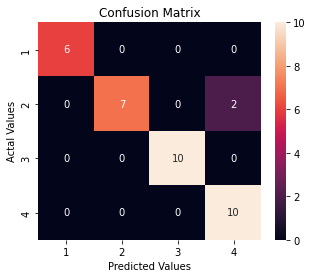

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm,
                     index = ['1','2','3','4'], 
                     columns = ['1','2','3','4'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## n_significant = 0

In [25]:
selected = list(X_train_filtered_multi_0.columns.values)

X_train_filtered = X_train[selected]
X_test_filtered = X_test[selected]

print(X_train_filtered.shape)
print(X_test_filtered.shape)

(51, 2178)
(35, 2178)


In [ ]:
import timeit
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

start = timeit.default_timer()

model = CatBoostClassifier(
    learning_rate=0.5,
    l2_leaf_reg=7,
    depth=4,
    loss_function='MultiClass',
)

model = CatBoostClassifier(
    learning_rate=0.35,
    l2_leaf_reg=1,
    depth=3,
    loss_function='MultiClass',
)


model.fit(X_train_filtered, y_train)
y_pred = model.predict(X_test_filtered)
score = accuracy_score(y_test, y_pred)
error_rate = 1-score

stop = timeit.default_timer()


In [27]:
print('Time: ', stop - start) 
print(error_rate)

Time:  54.299598414
0.05714285714285716


In [ ]:
#Applying the K-Fold Cross Validation for CatBoost
from sklearn.model_selection import cross_val_score

accuracies = cross_val_score(estimator = model, X = X, y = y, cv = 5)

In [35]:
accuracies

array([1.        , 0.88235294, 0.94117647, 1.        , 0.88235294])

In [34]:
print("Accuracy:{:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation:{:.2f} %".format(accuracies.std()*100))

Accuracy:94.12 %
Standard Deviation:5.26 %


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm,
                     index = ['1','2','3','4'], 
                     columns = ['1','2','3','4'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## n_significant = 1

In [ ]:
selected = list(X_train_filtered_multi_1.columns.values)

X_train_filtered = X_train[selected]
X_test_filtered = X_test[selected]

print(X_train_filtered.shape)
print(X_test_filtered.shape)

import timeit
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

start = timeit.default_timer()

model = CatBoostClassifier(
    learning_rate=0.5,
    l2_leaf_reg=7,
    depth=4,
    loss_function='MultiClass',
)

model = CatBoostClassifier(
    learning_rate=0.35,
    l2_leaf_reg=1,
    depth=3,
    loss_function='MultiClass',
)


model.fit(X_train_filtered, y_train)
y_pred = model.predict(X_test_filtered)
score = accuracy_score(y_test, y_pred)
error_rate = 1-score

stop = timeit.default_timer()


In [168]:
print('Time: ', stop - start) 

Time:  15.68012389100113


In [169]:
print(error_rate)

0.08571428571428574


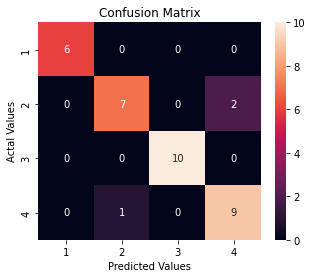

In [170]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm,
                     index = ['1','2','3','4'], 
                     columns = ['1','2','3','4'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [171]:
y_test.value_counts()

4    10
3    10
2     9
1     6
Name: class, dtype: int64

## n_significant = 2

In [188]:
'''
Input 
'''
selected = list(X_train_filtered_multi_2.columns.values)

X_train_filtered = X_train[selected]
X_test_filtered = X_test[selected]

print(X_train_filtered.shape)
print(X_test_filtered.shape)

(51, 242)
(35, 242)


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import timeit
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

start = timeit.default_timer()

model = CatBoostClassifier(
    learning_rate=0.5,
    l2_leaf_reg=7,
    depth=4,
    loss_function='MultiClass',
)

model = CatBoostClassifier(
    learning_rate=0.35,
    l2_leaf_reg=1,
    depth=3,
    loss_function='MultiClass',
)


model.fit(X_train_filtered, y_train)
y_pred = model.predict(X_test_filtered)
score = accuracy_score(y_test, y_pred)
error_rate = 1-score

stop = timeit.default_timer()
print('Time: ', stop - start) 

In [190]:
print('Time: ', stop - start)

Time:  6.951249710999036


In [191]:
print(error_rate)

0.05714285714285716


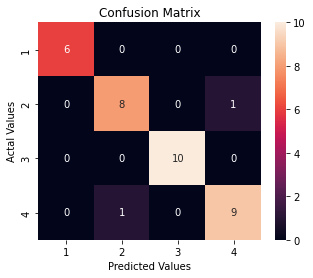

In [192]:
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm,
                     index = ['1','2','3','4'], 
                     columns = ['1','2','3','4'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## n_significant = 3

In [177]:
'''
Input 
'''
selected = list(X_train_filtered_multi_3.columns.values)

X_train_filtered = X_train[selected]
X_test_filtered = X_test[selected]

print(X_train_filtered.shape)
print(X_test_filtered.shape)

(51, 22)
(35, 22)


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import timeit

start = timeit.default_timer()

model = CatBoostClassifier(
    learning_rate=0.5,
    l2_leaf_reg=7,
    depth=4,
    loss_function='MultiClass',
)

model = CatBoostClassifier(
    learning_rate=0.35,
    l2_leaf_reg=1,
    depth=3,
    loss_function='MultiClass',
)


model.fit(X_train_filtered, y_train)
y_pred = model.predict(X_test_filtered)
score = accuracy_score(y_test, y_pred)
error_rate = 1-score

stop = timeit.default_timer()
print('Time: ', stop - start) 

In [179]:
print('Time: ', stop - start) 

Time:  1.1010021040001448


In [180]:
print(error_rate)

0.1428571428571429


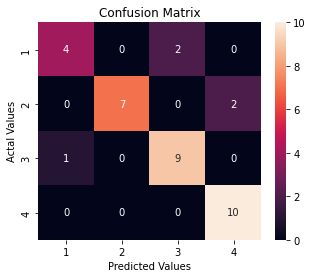

In [181]:
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm,
                     index = ['1','2','3','4'], 
                     columns = ['1','2','3','4'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()